In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from keras.models import Model, Sequential
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import activations, initializers, regularizers, constraints
from keras.utils.conv_utils import conv_output_length
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.initializers import glorot_uniform
from keras.preprocessing import text, sequence
from keras.regularizers import l2
from keras.constraints import maxnorm
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import metrics
import numpy as np 
import pandas as pd 
import os
np.random.seed(0)
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from wordcloud import WordCloud
from matplotlib import rcParams
from collections import Counter
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

### load pre-processed train / test / validation data

In [3]:
X_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/X_train.csv')
X_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/X_test.csv')
y_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/y_train.csv')
y_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/y_test.csv')
X_val = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/X_val.csv')
y_val = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/y_val.csv')

In [4]:
X_train = X_train.iloc[:,0]
X_test = X_test.iloc[:,0]
y_train = y_train.iloc[:,0]
y_test = y_test.iloc[:,0]
X_val = X_val.iloc[:,0]
y_val = y_val.iloc[:,0]
X_train

0        worse tea fresh green tea indeed green tea tim...
1        ive tasted best real things wonderful dreadful...
2        love taste good ginger snap cookie saw offered...
3        absolutely love coachs oatmeal hated oatmeal t...
4        normally dont go instant coffees delicious ins...
                               ...                        
96058    ive loved graham crackers since kid many brand...
96059    decided give try since kcup coffee prices goin...
96060    excellent coffee either brewed hot ice drink l...
96061    reading useful negative review times comment t...
96062    excited high protein pretzels opened tasted ta...
Name: text, Length: 96063, dtype: object

In [5]:
print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(y_train)))
print('Valid data len:'+str(len(X_val)))
print('Class distribution'+ str(Counter(y_val)))
print('Test data len:'+str(len(X_test)))
print('Class distribution'+ str(Counter(y_test)))

Train data len:96063
Class distributionCounter({1: 80198, 0: 15865})
Valid data len:32021
Class distributionCounter({1: 26724, 0: 5297})
Test data len:32022
Class distributionCounter({1: 26731, 0: 5291})


### vectorize a text corpus, by turning each text into either a sequence of integers using keras oov tokenizer
- num_words : the maximum number of words to keep, based on word frequency. 


In [6]:
num_words = 50000 #the maximum number of words to keep, based on word frequency. Only the most common num_words-1 words will be kept

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(X_train)


print(str(tokenizer.texts_to_sequences(['coffee pretzel tea'])))

[[4, 1800, 13]]


### create train,validation and test tensorflow datasets

In [7]:
x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_val = np.array( tokenizer.texts_to_sequences(X_val) )
x_test  = np.array( tokenizer.texts_to_sequences(X_test) )



x_train = pad_sequences(x_train, padding='post', maxlen=100)
x_val = pad_sequences(x_val, padding='post', maxlen=100)
x_test = pad_sequences(x_test, padding='post', maxlen=100)


train_labels = np.asarray(y_train)
val_labels = np.asarray(y_val)
test_labels = np.asarray(y_test)

print('Train data len:'+str(len(x_train)))
print('Class distribution'+str(Counter(train_labels)))

print('Validation data len:'+str(len(x_val)))
print('Class distribution'+str(Counter(val_labels)))

print('Test data len:'+str(len(x_test)))
print('Class distribution'+str(Counter(test_labels)))


train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((x_val,val_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify

Train data len:96063
Class distributionCounter({1: 80198, 0: 15865})
Validation data len:32021
Class distributionCounter({1: 26724, 0: 5297})
Test data len:32022
Class distributionCounter({1: 26731, 0: 5291})


In [8]:
count =0
print('======Train dataset ====')
for value,label in train_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Validation dataset ====')
for value,label in val_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Test dataset ====')
for value,label in test_ds:
    count += 1
    print(value,label)
    if count==1:
        break  

======Train dataset ====
tf.Tensor(
[ 1162    13   173   139    13  1943   139    13    24  1787  1064  3535
  1072   854 19596  3151 10488  1059    36    13   933     9    17    71
   102    13   571   313  1272   103   102   700  1072  1059  1176     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0], shape=(100,), dtype=int32) tf.Tensor(0, shape=(), dtype=int64)
======Validation dataset ====
tf.Tensor(
[  158   285   770    41  2067  7256   320   106   574  3374    41   101
    41   607  2997     7   352   250    37  1478  2217   462     7   406
    41   532  6709    42    41   322   124   244    41  3712     3   326
    41   770   285  5301  1427

### create a simple LSTM based sentiment classification model

In [9]:
max_features =50000 # size of vocabulary
embedding_dim =16
sequence_length = 100

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.005))) 
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.LSTM(embedding_dim,dropout=0.2, recurrent_dropout=0.2,return_sequences=True,\
                                                             kernel_regularizer=regularizers.l2(0.005),\
                                                             bias_regularizer=regularizers.l2(0.005)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(8, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))


model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
                               



model.summary()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(1e-3),metrics=[tf.keras.metrics.BinaryAccuracy()])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           800016    
                                                                 
 dropout (Dropout)           (None, 100, 16)           0         
                                                                 
 lstm (LSTM)                 (None, 100, 16)           2112      
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 512)               819712    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 4

### model fittling

In [10]:
epochs = 10
history = model.fit(train_ds.shuffle(5000).batch(1024),
                    epochs= epochs ,
                    validation_data=val_ds.batch(1024),
                    verbose=1)

Epoch 1/10
94/94 [==============================] - 61s 603ms/step - loss: 1.3026 - binary_accuracy: 0.8311 - val_loss: 0.4659 - val_binary_accuracy: 0.8346
Epoch 2/10
94/94 [==============================] - 54s 570ms/step - loss: 0.4422 - binary_accuracy: 0.8348 - val_loss: 0.3762 - val_binary_accuracy: 0.8346
Epoch 3/10
94/94 [==============================] - 54s 574ms/step - loss: 0.3998 - binary_accuracy: 0.8873 - val_loss: 0.3678 - val_binary_accuracy: 0.9169
Epoch 4/10
94/94 [==============================] - 54s 578ms/step - loss: 0.3788 - binary_accuracy: 0.9073 - val_loss: 0.3432 - val_binary_accuracy: 0.9216
Epoch 5/10
94/94 [==============================] - 53s 562ms/step - loss: 0.3677 - binary_accuracy: 0.9090 - val_loss: 0.3463 - val_binary_accuracy: 0.9242
Epoch 6/10
94/94 [==============================] - 52s 556ms/step - loss: 0.3574 - binary_accuracy: 0.9117 - val_loss: 0.3393 - val_binary_accuracy: 0.9245
Epoch 7/10
94/94 [==============================] - 52s 55

In [11]:
history.history

{'binary_accuracy': [0.8311108350753784,
  0.8348479866981506,
  0.8872823119163513,
  0.9072691798210144,
  0.9089660048484802,
  0.9117454290390015,
  0.913598358631134,
  0.9143791198730469,
  0.9122138619422913,
  0.914233386516571],
 'loss': [1.3025542497634888,
  0.4422155022621155,
  0.3998012840747833,
  0.37882745265960693,
  0.36765870451927185,
  0.3573700785636902,
  0.35069093108177185,
  0.3447801172733307,
  0.34014108777046204,
  0.33402469754219055],
 'val_binary_accuracy': [0.8345773220062256,
  0.8345773220062256,
  0.9168983101844788,
  0.9216451644897461,
  0.9242371916770935,
  0.9244558215141296,
  0.9267980456352234,
  0.9255800843238831,
  0.9278910756111145,
  0.9297336339950562],
 'val_loss': [0.46587392687797546,
  0.37615829706192017,
  0.36780714988708496,
  0.3431587517261505,
  0.34625759720802307,
  0.3393189311027527,
  0.3173274099826813,
  0.31160417199134827,
  0.3090318739414215,
  0.30775371193885803]}

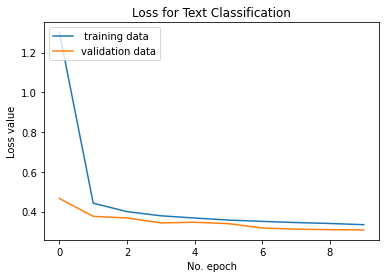

In [12]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

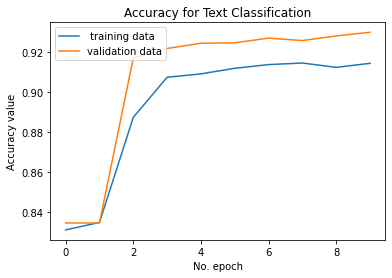

In [13]:
plt.plot(history.history['binary_accuracy'], label=' training data')
plt.plot(history.history['val_binary_accuracy'], label='validation data')
plt.title('Accuracy for Text Classification')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

### Lets save our model and tokenizer

In [14]:
model.save('./tf_lstmmodel.h5') 
json_string = tokenizer.to_json()

In [15]:
import json
with open('./tokenizer.json', 'w') as outfile:
    json.dump(json_string, outfile)

In [16]:
valid_predict= model.predict(x_val)

In [17]:
print(valid_predict[:10])

[[0.99999595]
 [0.9999191 ]
 [1.        ]
 [0.9985198 ]
 [0.9999619 ]
 [0.97671247]
 [0.7107624 ]
 [0.8322674 ]
 [0.9984058 ]
 [0.9995674 ]]


### To find optimal threshold, draw ROC curve

In [18]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, thresholds = sklearn.metrics.roc_curve(labels, predictions)
    plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives Rate')
    plt.ylabel('True positives Rate')
    plt.xlim([-0.03, 1.0])
    plt.ylim([0.0, 1.03])
    plt.grid(True)
    thresholdsLength = len(thresholds)
    thresholds_every = 1000
    colorMap = plt.get_cmap('jet', thresholdsLength)
    for i in range(0, thresholdsLength, thresholds_every):
        threshold_value_with_max_four_decimals = str(thresholds[i])[:5]
        plt.text(fp[i] - 0.03, tp[i] + 0.001, threshold_value_with_max_four_decimals, fontdict={'size': 15}, color=colorMap(i/thresholdsLength));

    ax = plt.gca()
    ax.set_aspect('equal')

In [19]:
mpl.rcParams['figure.figsize'] = (10, 10)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

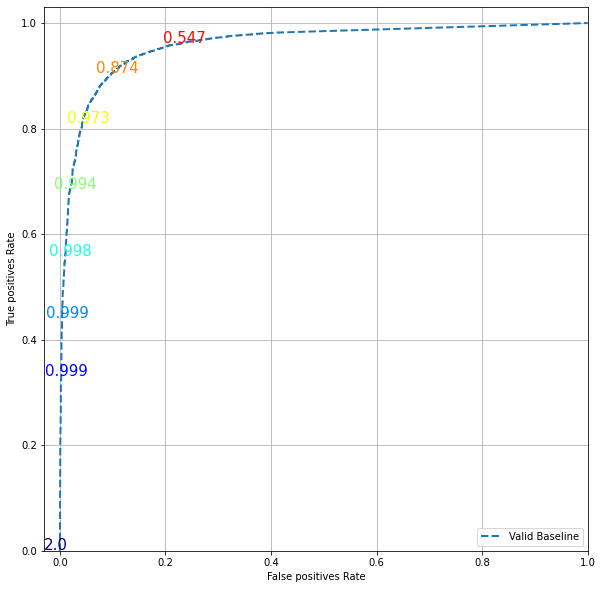

In [20]:
plot_roc("Valid Baseline", val_labels, valid_predict, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [21]:
y_true = y_val
y_scores = valid_predict

fpr, tpr, thresholds = metrics.roc_curve(y_true, y_scores)
print(tpr)
print(fpr)
print(thresholds)
print(metrics.roc_auc_score(y_true, y_scores))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)

[0.         0.05620416 0.05848675 ... 0.98211346 0.98211346 1.        ]
[0.00000000e+00 1.88786105e-04 1.88786105e-04 ... 4.17594865e-01
 4.18161223e-01 1.00000000e+00]
[2.         1.         0.9999999  ... 0.40888903 0.4088847  0.40888458]
0.9596761490358501
Threshold value is: 0.8766271


In [22]:
new_model = tf.keras.models.load_model('./tf_lstmmodel.h5')
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           800016    
                                                                 
 dropout (Dropout)           (None, 100, 16)           0         
                                                                 
 lstm (LSTM)                 (None, 100, 16)           2112      
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 512)               819712    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 4

### load the model we build and test on test data

In [23]:
with open('./tokenizer.json') as json_file:
    json_string = json.load(json_file)
tokenizer1 = tf.keras.preprocessing.text.tokenizer_from_json(json_string)

In [24]:
predictions = new_model.predict(x_test)

### we will use the optimal threshold to have binary classification

In [39]:
predictions_binary= predictions
predictions_binary = np.where((predictions_binary >= 0.87),1,predictions_binary)
predictions_binary = np.where((predictions_binary < 0.87),0,predictions_binary)

### confusion matrix

In [40]:
print(classification_report(y_test,predictions_binary))

              precision    recall  f1-score   support

           0       0.65      0.90      0.76      5291
           1       0.98      0.91      0.94     26731

    accuracy                           0.90     32022
   macro avg       0.82      0.90      0.85     32022
weighted avg       0.92      0.90      0.91     32022



In [41]:
predictions_binary= predictions
predictions_binary = np.where((predictions_binary >= 0.5),1,predictions_binary)
predictions_binary = np.where((predictions_binary < 0.5),0,predictions_binary)

In [42]:
print(classification_report(y_test,predictions_binary))

              precision    recall  f1-score   support

           0       0.80      0.75      0.78      5291
           1       0.95      0.96      0.96     26731

    accuracy                           0.93     32022
   macro avg       0.88      0.86      0.87     32022
weighted avg       0.93      0.93      0.93     32022

